# Dependencias


In [54]:
!py -m pip install gradio
!py -m pip install tqdm
!py -m pip install torch
!py -m pip install tensorflow
!py -m pip install keras

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import gradio as gr
import pandas as pd
import numpy as np
import torch
import torch.nn as nn, torch.optim as optim
#import torch.nn.functional as F
#import torch.nn.utils.prune as prune
from tqdm import tqdm
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import h5py
import scipy.signal  as sgn
from source import engines 


C:\Users\quin-\AppData\Roaming\Python\Python37\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'source'

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [13]:
!ls

"ls" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [15]:
pathModels = "./Modelos"

# Predicts

In [52]:
def predict(
    train_loaders, 
    model, 
    config,
    training_verbose = True, 
):
    model = torch.load(f"{pathModels}/best.ptl", map_location=torch.device('cpu'))
    #model = nn.DataParallel(model, device_ids = config["device_ids"])
    
    with torch.no_grad():
        model.eval()
        running_labels, running_preds = [], []
        for ecgs, labels in tqdm(train_loaders["pred"], disable = not training_verbose):  
            ecgs, labels = ecgs.cpu(), labels.cpu()
            logits = model(ecgs)

            #labels son las etiquetas reales y preds las que ha predicho el modelo
            labels, preds = list(labels.data.cpu().numpy()), list(torch.max(logits, 1)[1].detach().cpu().numpy()) if not config["is_multilabel"] else list(torch.sigmoid(logits).detach().cpu().numpy())
            running_labels.extend(labels), running_preds.extend(preds)

    if config["is_multilabel"]:
        running_labels, running_preds = np.array(running_labels), np.array(running_preds)
        #optimal_thresholds = thresholds_search(running_labels, running_preds)
        optimal_thresholds = pd.read_csv("./thresholds/CPSC-2018/optimal_thresholds_best.csv")
        running_preds = np.stack([
            np.where(running_preds[:, cls] >= optimal_thresholds[cls], 1, 0) for cls in range(running_preds.shape[1])
        ]).transpose()
    else:   
        #########################PRUEBA########################
        running_labels, running_preds = np.array(running_labels), np.array(running_preds)
        #Te quedas con los umbrales que tienen un mejor f1_score
        running_labels=np.reshape(running_labels, (len(running_labels),-1))
        running_preds=np.reshape(running_preds, (len(running_preds),-1))
        #optimal_thresholds = thresholds_search(running_labels,running_preds)
        optimal_thresholds = pd.read_csv()
        running_preds = np.stack([
            np.where(running_preds[:, cls] >= optimal_thresholds[cls], 1, 0) for cls in range(running_preds.shape[1])
        ]).transpose()
        ########################################################

    return running_preds


In [53]:
def predict_LightX3ECG(ecg, multilabel = True,num_gpus = 0):
    config = {
    "ecg_leads":[
        0, 1, 
        6, 
    ], 
    "ecg_length":5000, 
    "is_multilabel":multilabel, 
    "device_ids":list(range(num_gpus)), 
    }

    train_loaders = {
        "pred":torch.utils.data.DataLoader(
            ECGDataset(
                df_path = f"{configVars.pathCasos}{args.dataset}/pred.csv", data_path = f"{configVars.pathCasos}{args.dataset}/CasosNumpy", 
                config = config, 
                augment = False, 
            ), 
            num_workers = 8, batch_size = 64, 
            shuffle = False
        )
        }

    model = LightX3ECG(
        num_classes = args.num_classes, 
        )


    return predict(
            train_loaders, 
            model, 
            config,
            save_ckp_dir = save_ckp_dir, 
            training_verbose = True, 
        )

In [21]:
def predict_CPSC_2018(ecg):
  #model = torch.load(f"{pathModels}/CPSC-2018/best.ptl", map_location = "cuda") # carga el modelo en una gpu
  model = torch.load(f"{pathModels}/CPSC-2018/best.ptl", map_location=torch.device('cpu')) #carga el modelo en la cpu
  # cosas para el paralelismo
  #model = nn.DataParallel(model, device_ids = config["device_ids"])
  enfermedades = ['Normal','AF','I_AVB','LBBB','RBBB','PAC','PVC','STD','STE']
  with torch.no_grad():
        model.eval()
        running_labels, running_preds = [], []
        for ecgs, labels in tqdm(train_loaders["pred"], disable = not training_verbose):  
            ecgs, labels = ecgs.cuda(), labels.cuda()
            logits = model(ecgs)

            #labels son las etiquetas reales y preds las que ha predicho el modelo
            #No tiene sentido hacer unos tresholds sin tener las clasificaciones correctas de las enfermedades, seguramente eliminar running_labels y labels
            labels, preds = list(labels.data.cpu().numpy()), list(torch.sigmoid(logits).detach().cpu().numpy()) if not config["is_multilabel"] else list(torch.sigmoid(logits).detach().cpu().numpy())
            running_labels.extend(labels), running_preds.extend(preds)

  running_labels, running_preds = np.array(running_labels), np.array(running_preds)
  #Te quedas con los umbrales que tienen un mejor f1_score
  print(f"El reshapeo del array{running_labels.shape}")
  print(f"El reshapeo del array{running_preds.shape}")
  optimal_thresholds = thresholds_search(running_labels, running_preds)
  running_probs = running_preds
  #No tiene sentido hacer unos tresholds sin tener las clasificaciones correctas de las enfermedades
  running_preds = np.stack([
      np.where(running_preds[:, cls] >= optimal_thresholds[cls], 1, 0) for cls in range(running_preds.shape[1])
  ]).transpose()
  

  result = ecg
  return result 

In [7]:
def predict_Chapman(ecg):
  model = torch.load(f"{pathModels}/Chapman/best.ptl", map_location = "cuda")
  # cosas para el paralelismo 
  #model = nn.DataParallel(model, device_ids = config["device_ids"])
  enfermedades = ['AFIB','GSVT','SB','SR']
  with torch.no_grad():
      model.eval()
      running_labels, running_preds = [], []
      for ecgs, labels in tqdm(train_loaders["pred"], disable = not training_verbose):  
          ecgs, labels = ecgs.cuda(), labels.cuda()
          logits = model(ecgs)

          #labels son las etiquetas reales y preds las que ha predicho el modelo
          #No tiene sentido hacer unos tresholds sin tener las clasificaciones correctas de las enfermedades, seguramente eliminar running_labels y labels
          labels, preds = list(labels.data.cpu().numpy()), list(torch.sigmoid(logits).detach().cpu().numpy()) if not config["is_multilabel"] else list(torch.sigmoid(logits).detach().cpu().numpy())
          running_labels.extend(labels), running_preds.extend(preds)
            
  running_preds,running_probs=getPredictedProbability(labels,preds)
  print(f"{np.shape(running_preds)}\n")
  print(f"{running_preds}\n")
  #########################PRUEBA########################
  running_labels, running_probs = np.array(running_labels), np.array(running_probs)
  running_labels=np.reshape(running_labels, (len(running_labels),-1))
  running_preds=np.reshape(running_preds, (len(running_preds),-1))
  running_probs=np.reshape(running_probs, (len(running_probs),-1))
  optimal_thresholds=[]
  ######################################################## 

  result = ecg
  return result

In [8]:
def predict_antonior92(ecg):
  model = load_model(f"{pathModels}/antonior92/model.hdf5", compile=False)
  model.compile(loss='binary_crossentropy', optimizer=Adam())
  result = model.predict(ecg,  verbose=1)
  #result = model.predict(ecg)
  enfermedades = np.array(['Normal','1dAVb', 'RBBB', 'LBBB', 'SB', 'AF', 'ST'])
 
  selected = [True,False,True,False,False,True,False]
  #result = enfermedades[selected]
  return result.tolist()

In [68]:
%cd ..

e:\automatic-ecg-diagnosis-private


In [87]:
import h5py
from tensorflow.keras.models import load_model
f = h5py.File("automatic-ecg-diagnosis/data/ecg_tracings2.hdf5", 'r')
print(f['tracings'])
f.close()

<HDF5 dataset "tracings": shape (827, 4096, 12), type "<f8">


In [82]:
import h5py
from tensorflow.keras.models import load_model
f = h5py.File("Interfaz/datasets/pred.hdf5", 'r')
print(f['tracings'])
f.close()

<HDF5 dataset "tracings": shape (1, 4096, 12), type "<f8">


# Funciones auxiliares

In [8]:
file = 'MUSE_20180111_155203_15000'
data = np.load(f'{file}.npy')
df = pd.DataFrame(data)
df.to_csv(f'{file}.csv',index=False,header=False)

In [9]:
def remove_baseline_filter(sample_rate):
    fc = 0.8  # [Hz], cutoff frequency
    fst = 0.2  # [Hz], rejection band
    rp = 0.5  # [dB], ripple in passband
    rs = 40  # [dB], attenuation in rejection band
    wn = fc / (sample_rate / 2)
    wst = fst / (sample_rate / 2)

    filterorder, aux = sgn.ellipord(wn, wst, rp, rs)
    sos = sgn.iirfilter(filterorder, wn, rp, rs, btype='high', ftype='ellip', output='sos')

    return sos

In [10]:
reduced_leads = ['DI', 'DII', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
all_leads = ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

def preprocess_ecg(ecg, sample_rate, leads, new_freq=None, new_len=None, scale=1,
                   use_all_leads=True, remove_baseline=False, powerline=None):
    print(ecg.shape)
    # Remove baseline
    if remove_baseline:
        sos = remove_baseline_filter(sample_rate)
        ecg_nobaseline = sgn.sosfiltfilt(sos, ecg, padtype='constant', axis=-1)
    else:
        ecg_nobaseline = ecg
    print(ecg_nobaseline.shape)

    # Remove powerline
    if powerline is None:
        ecg_nopowerline = ecg_nobaseline
    else:
        # Design notch filter
        q = 30.0  # Quality factor
        b, a = sgn.iirnotch(powerline, q, fs=sample_rate)
        ecg_nopowerline = sgn.filtfilt(b, a, ecg_nobaseline)
    print(ecg_nopowerline.shape)

    # Resample
    if new_freq is not None:
        print("none")
        ecg_resampled = sgn.resample_poly(ecg_nopowerline, up=new_freq, down=sample_rate, axis=-1)
    else:
        print("else")
        ecg_resampled = ecg_nopowerline
        new_freq = sample_rate
    n_leads, length = ecg_resampled.shape
    print(ecg_resampled.shape)

    # Rescale
    ecg_rescaled = scale * ecg_resampled
    print(ecg_rescaled.shape)

    # Add leads if needed
    target_leads = all_leads if use_all_leads else reduced_leads
    n_leads_target = len(target_leads)
    l2p = dict(zip(target_leads, range(n_leads_target)))
    ecg_targetleads = np.zeros([n_leads_target, length])
    print(l2p)
    print(ecg_rescaled.shape)
    print(ecg_targetleads.shape)
    ecg_targetleads = ecg_rescaled
    #for i, l in enumerate(leads):
    #    if l in target_leads:
    #        #ecg_targetleads[l2p[l], :] = ecg_rescaled[i, :]
    #        ecg_targetleads[l2p[l], :] = ecg_rescaled[:]
    if n_leads_target >= n_leads and use_all_leads:
        ecg_targetleads[l2p['DIII'], :] = ecg_targetleads[l2p['DII'], :] - ecg_targetleads[l2p['DI'], :]
        ecg_targetleads[l2p['AVR'], :] = -(ecg_targetleads[l2p['DI'], :] + ecg_targetleads[l2p['DII'], :]) / 2
        ecg_targetleads[l2p['AVL'], :] = (ecg_targetleads[l2p['DI'], :] - ecg_targetleads[l2p['DIII'], :]) / 2
        ecg_targetleads[l2p['AVF'], :] = (ecg_targetleads[l2p['DII'], :] + ecg_targetleads[l2p['DIII'], :]) / 2
    
    ###################################
    #ecg_targetleads = ecg_rescaled
    ###################################

    # Reshape
    if new_len is None or new_len == length:
        ecg_reshaped = ecg_targetleads
    elif new_len > length:
        ecg_reshaped = np.zeros([n_leads_target, new_len])
        pad = (new_len - length) // 2
        ecg_reshaped[..., pad:length+pad] = ecg_targetleads
    else:
        extra = (length - new_len) // 2
        ecg_reshaped = ecg_targetleads[:, extra:new_len + extra]

    return ecg_reshaped, new_freq, target_leads

## generateH5

In [11]:
def generateH5(input_file,out_file,new_freq=None,new_len=None,scale=1,powerline=None,use_all_leads=True,remove_baseline=False,root_dir=None,fmt='wfdb'):
    n = len(input_file)  # Get length
    try:
      h5f = h5py.File(out_file, 'r+')
      h5f.clear()
    except:
      h5f = h5py.File(out_file, 'w')

    ecg = input_file 
    sample_rate, leads = input_file.shape
  
    ecg_preprocessed = ecg.T
    n_leads, n_samples = ecg_preprocessed.shape
    x = h5f.create_dataset('tracings', (1, n_samples, n_leads), dtype='f8')
    print(ecg_preprocessed.T)
    x[0, :, :] = ecg_preprocessed.T

    h5f.close()

In [ ]:
engines.predict

In [45]:
datos = pd.read_csv("Caso1.csv",names=['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'],dtype=np.double)

model = torch.load(f"{pathModels}/CPSC-2018/best.ptl", map_location=torch.device('cpu'))
inp = [[]]
inp[0] = datos.values
print(inp)
tensor_entrada = torch.tensor(inp,dtype=torch.double)
print(tensor_entrada.shape)
pred = model(tensor_entrada)
pred

[array([[  73.,  -31., -104., ...,  -64.,   33.,  -11.],
       [  69.,  -32., -101., ...,  -64.,   32.,  -11.],
       [  68.,  -34., -102., ...,  -64.,   31.,  -12.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])]
torch.Size([1, 5500, 12])


RuntimeError: expected scalar type Double but found Float

# procesar_archivo

In [18]:
def procesar_archivo(formato,sexo,edad,archivo):
  datos = []
  if(formato == 'XML'):
    datos = pd.read_csv(archivo.name,names=['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
  else:
    datos = pd.read_csv(archivo,names=['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
  ###########################
  ### cambio de formato para poder predecir ###
  #datos = datos.values[:4096,:]
  ###########################
  #generateH5(datos,
  #         "ecg.hdf5",new_freq=400,new_len=4096,
  #         scale=2,powerline=None,use_all_leads=True,
  #         remove_baseline=False,root_dir=None,fmt='wfdb')
  #f = h5py.File("ecg.hdf5", 'r')
  #antonior92 = predict_antonior92(f['tracings'])
  #f.close()
  antonior92 = []
  CPSC = predict_CPSC_2018(datos)
  #CPSC = []
  #Chapman = predict_Chapman(datos)
  Chapman =[]
  result = pd.DataFrame(data = [['Antonior92',antonior92],['CPSC-2018',CPSC],['Chapman',Chapman]],columns=['Red','Predicción'],)
  #result = pd.DataFrame()
  print(result)

  return result

In [25]:
procesar_archivo('CSV',0,0,'Caso1.csv')

NameError: name 'train_loaders' is not defined

# Interfaz


In [22]:
def saveResponse(formato,sexo,edad,archivo):
  archivo.to_csv()
# Crear la interfaz web
entrada = [
        gr.inputs.Dropdown(["XML","CSV"],default="XML",label= "Formato del archivo"),
        gr.inputs.Dropdown(["Hombre","Mujer"],default="Hombre",label= "Sexo"),
        gr.inputs.Slider(label= "Edad",default=25),
        gr.inputs.File(label="Selecciona un archivo.")
        ]

salida = gr.outputs.Dataframe(label="Predicción automática.",type="pandas",headers = ['Red','Predicción'])


Interface = gr.Interface(fn=procesar_archivo, inputs=entrada, outputs=salida, title="Analizador automático de ECG",flagging_dir="./salida/")
Interface.launch()


C:\Users\quin-\AppData\Roaming\Python\Python37\site-packages\gradio\inputs.py:220: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
C:\Users\quin-\AppData\Roaming\Python\Python37\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\quin-\AppData\Roaming\Python\Python37\site-packages\gradio\inputs.py:90: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
C:\Users\quin-\AppData\Roaming\Python\Python37\site-packages\gradio\inputs.py:350: UserWarning:

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "C:\Users\quin-\AppData\Roaming\Python\Python37\site-packages\gradio\routes.py", line 419, in run_predict
    event_data=event_data,
  File "C:\Users\quin-\AppData\Roaming\Python\Python37\site-packages\gradio\blocks.py", line 1300, in process_api
    fn_index, inputs, iterator, request, event_id, event_data
  File "C:\Users\quin-\AppData\Roaming\Python\Python37\site-packages\gradio\blocks.py", line 1022, in call_function
    fn, *processed_input, limiter=self.limiter
  File "C:\Users\quin-\AppData\Roaming\Python\Python37\site-packages\anyio\to_thread.py", line 32, in run_sync
    func, *args, cancellable=cancellable, limiter=limiter
  File "C:\Users\quin-\AppData\Roaming\Python\Python37\site-packages\anyio\_backends\_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "C:\Users\quin-\AppData\Roaming\Python\Python37\site-packages\anyio\_backends\_asyncio.py", line 867, in run
    result = context.run(func, *args)
 

# cosas

In [36]:
npy = np.load('MUSE_20180111_155203_15000.npy')
npy.shape

(12, 5000)

In [73]:
csv = pd.read_csv('Caso1.csv',header=None)
csv.shape

(5500, 12)

In [74]:
csv.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,73,-31,-104,-21.0,88.5,-67.5,-42,3,-22,-64,33,-11
1,69,-32,-101,-18.5,85.0,-66.5,-43,3,-22,-64,32,-11
2,68,-34,-102,-17.0,85.0,-68.0,-43,3,-22,-64,31,-12
3,67,-35,-102,-16.0,84.5,-68.5,-43,3,-22,-64,30,-13
4,66,-34,-100,-16.0,83.0,-67.0,-44,3,-22,-64,31,-13


In [75]:
np.save("prueba.npy",csv.T.values)


In [45]:
len(csv)

5500

In [38]:
csv2 = pd.read_csv('./datasets/pred.csv',header=None)
csv2.shape


(2, 14)

In [40]:
npy2 = np.load('./datasets/pred.npy')
npy2.shape

(12, 5500)

In [77]:
old = np.load('MUSE_20180111_155203_15000.npy')
old.shape

(12, 5000)

In [83]:
new = np.load('./datasets/pred.npy')
new.shape

(12, 7500)

In [7]:
import numpy as np
import pandas as pd

file = 'MUSE_20180111_155633_99000'
data = np.load(f'{file}.npy')
df = pd.DataFrame(data.T)
df.to_csv(f'{file}.csv',index=False,header=False)

In [4]:
import numpy as np
import pandas as pd
import h5py
args= "datasets/pred.hdf5"
with h5py.File(args, "r") as f:
    x = np.array(f['tracings'])

x.shape

(1, 4096, 12)

In [1]:
import numpy as np
import ecg_plot
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def ecgPlot(filename,source,sample, factor = 1):
    data = np.load(source)
    data = data* factor
    print(data.shape)
    xml_leads = ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    ecg_plot.plot(data, sample_rate= sample,lead_index=xml_leads, title=f"{filename}")

(12, 7500)


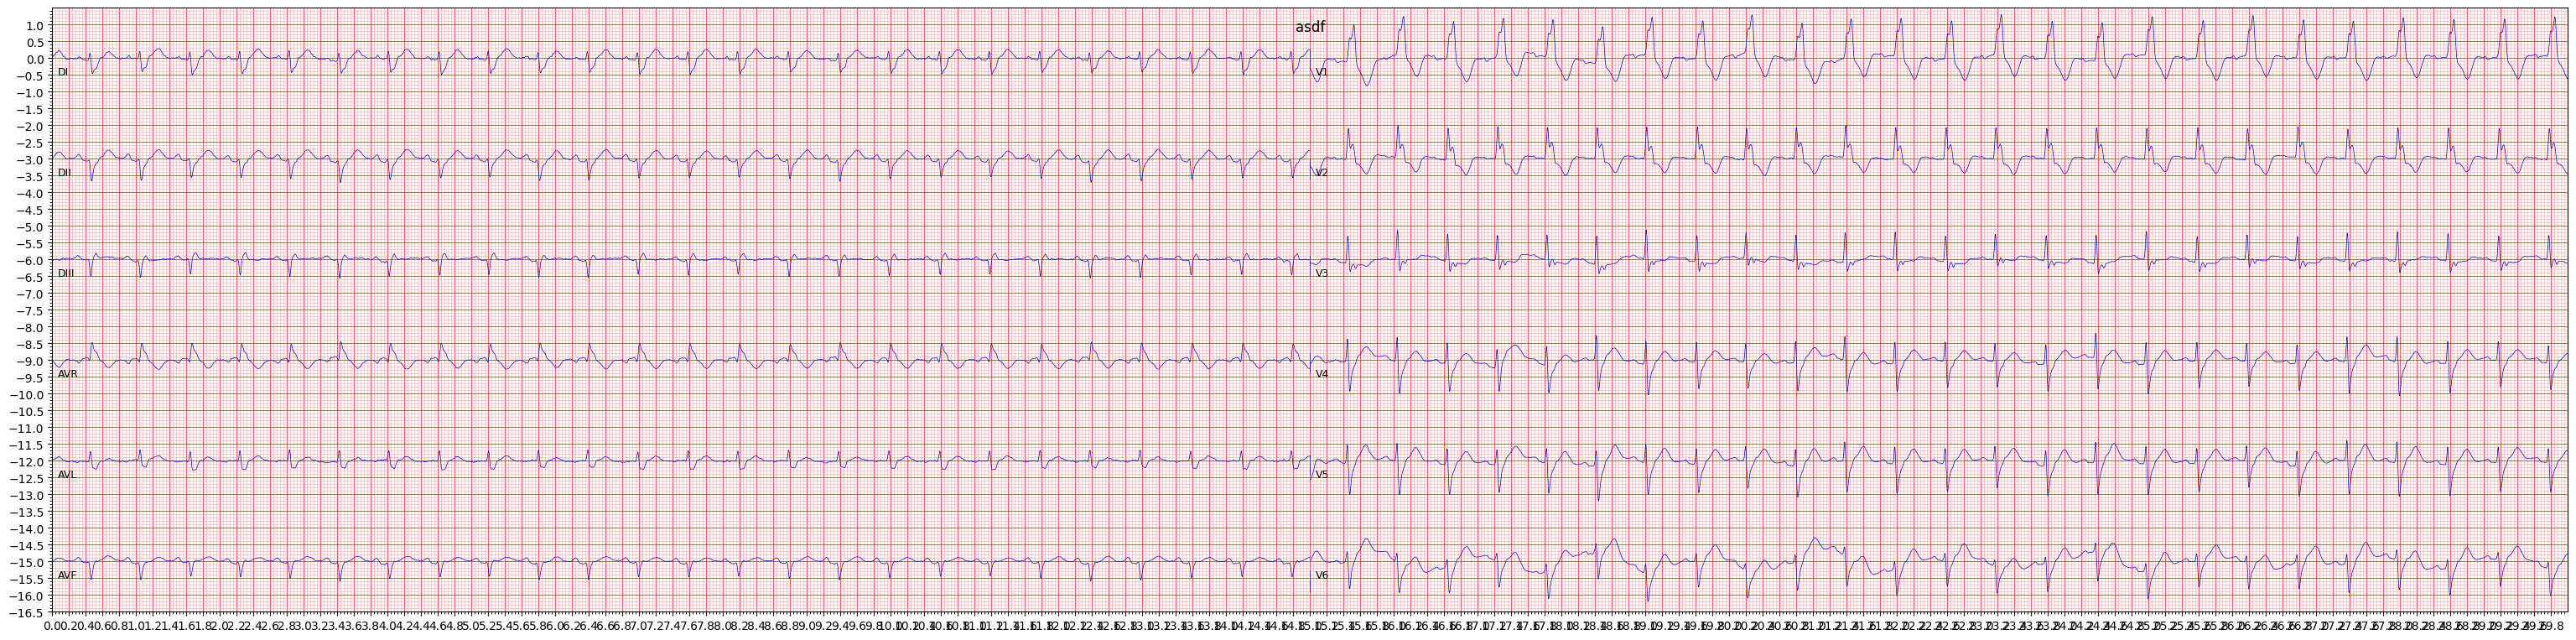

In [3]:
ecgPlot("asdf","prueba2.npy",500)

(12, 4096)


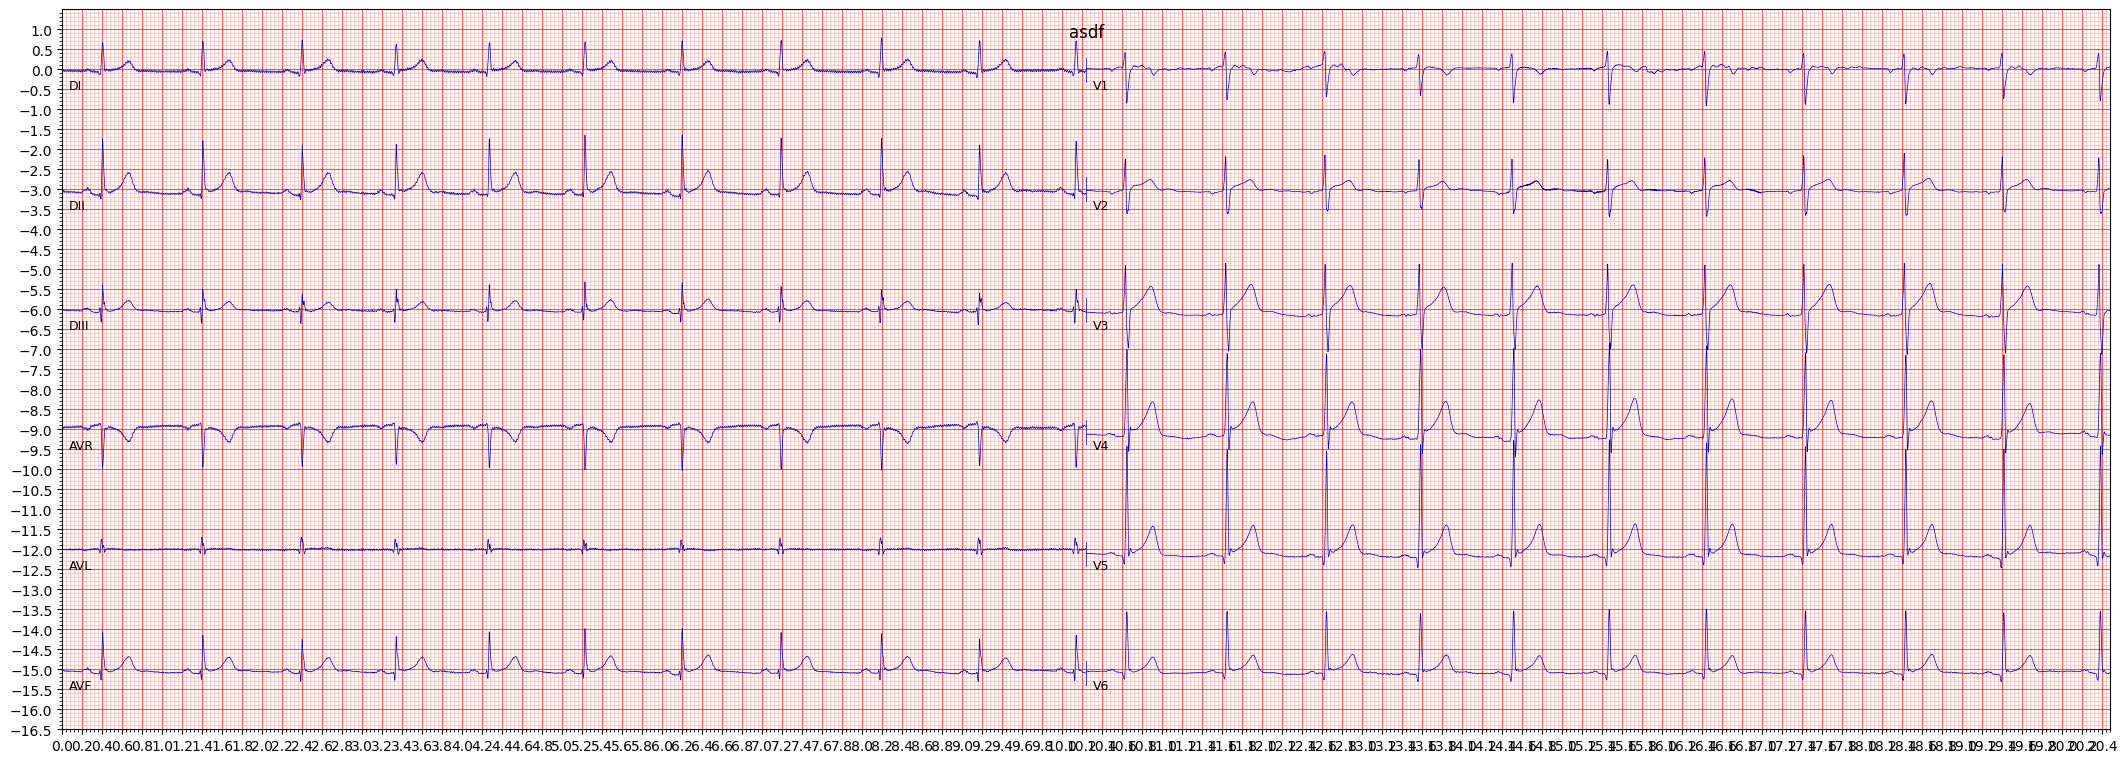

In [15]:
ecgPlot("asdf","prueba_prepro.npy",400)


(12, 7300)


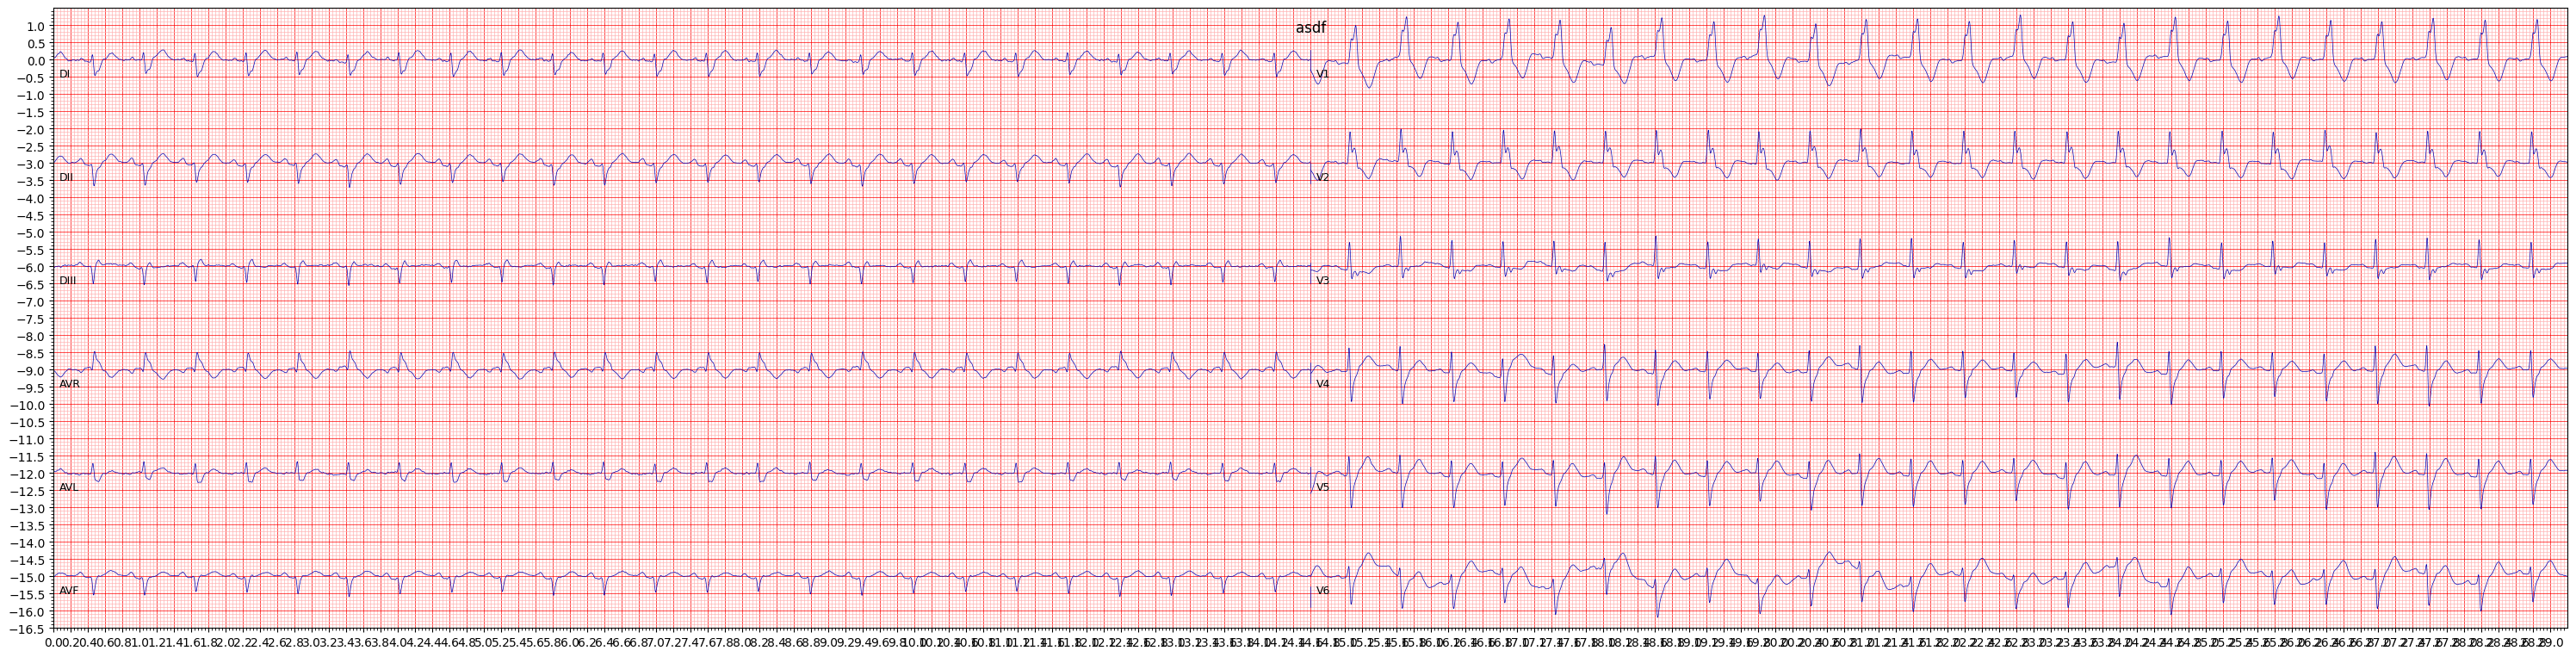

In [18]:
ecgPlot("asdf","datasets/pred.npy",500)

(12, 7300)


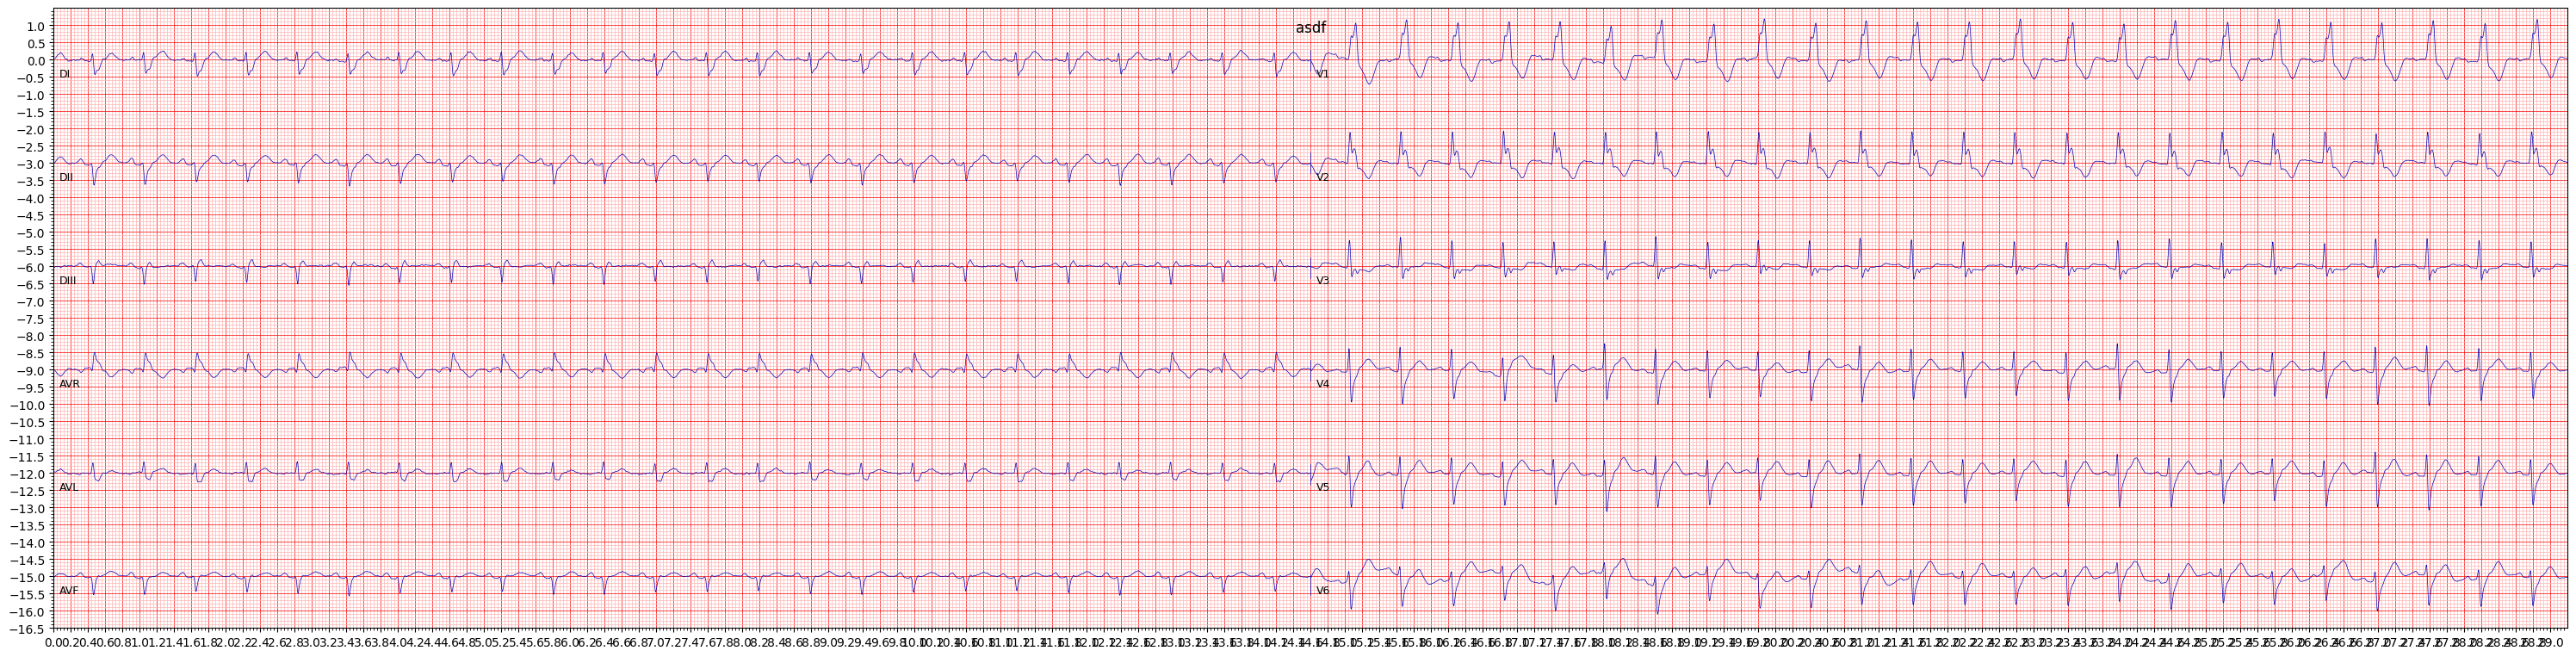

In [59]:
ecgPlot("asdf","datasets/pred.npy",500)

In [28]:
import gradio as gr

# Función para procesar la entrada
def process_input(value):
    return f"Valor: {value}, Unidad:"

# Opciones de unidades
unit_options = ["kg", "lb", "m", "ft"]

# Crear inputs y layout personalizado
layout = [
    gr.inputs.Number(label="Valor:"),
    gr.inputs.Dropdown(label="Unidad:", choices=unit_options)
]
input_grid = gr.Row(layout,elem_id=None)
# Crear la interfaz
interface = gr.Interface(fn=process_input, inputs=input_grid, outputs="text")
interface.launch()

C:\Users\quin-\AppData\Roaming\Python\Python37\site-packages\gradio\inputs.py:60: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
C:\Users\quin-\AppData\Roaming\Python\Python37\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\quin-\AppData\Roaming\Python\Python37\site-packages\gradio\inputs.py:220: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",


TypeError: __init__() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given

In [56]:
import gradio as gr
def fn(format,number,unit,frec,file):
    print(format)
    result = pd.DataFrame(data = [['Antonior92',[]],['CPSC-2018',[]],['Chapman',[]]],columns=['Red','Predicción'])
    ##return []
    return result

with gr.Blocks() as demo:
    with gr.Column():
        format = gr.inputs.Dropdown(["XML","CSV"],default="XML",label= "Formato del archivo")   
    with gr.Row():
        number = gr.inputs.Number(label="")
        unit = gr.inputs.Dropdown(["a", "b", "c"], label="")
    with gr.Column():
        frec = gr.inputs.Number(label= "Frecuencia (Hz)",default=500)
        file = gr.inputs.File(label="Selecciona un archivo.")
        button = gr.Button(value='Predict')
        out = gr.DataFrame(label="Predicción automática.",type="pandas",headers = ['Red','Predicción'])
        #out = gr.outputs.Dataframe(label="Predicción automática.",type="pandas",headers = ['Red','Predicción'])
    button.click(fn=fn,inputs=[format,number,unit,frec,file] ,outputs=out)
    
demo.launch()

C:\Users\quin-\AppData\Roaming\Python\Python37\site-packages\gradio\inputs.py:220: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
C:\Users\quin-\AppData\Roaming\Python\Python37\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\quin-\AppData\Roaming\Python\Python37\site-packages\gradio\inputs.py:60: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
C:\Users\quin-\AppData\Roaming\Python\Python37\site-packages\gradio\inputs.py:350: UserWarning:

Running on local URL:  http://127.0.0.1:7877

To create a public link, set `share=True` in `launch()`.


XML
